In [1]:
import pandas as pd

df = pd.read_csv('ecommerce_furniture_dataset_2024.csv')
df.head()


,productTitle,originalPrice,price,sold,tagText
0,Dresser For Bedroom With 9 Fabric Drawers Ward...,NaN,$46.79,600,Free shipping
1,Outdoor Conversation Set 4 Pieces Patio Furnit...,NaN,$169.72,0,Free shipping
2,Desser For Bedroom With 7 Fabric Drawers Organ...,$78.4,$39.46,7,Free shipping
3,"Modern Accent Boucle Chair,Upholstered Tufted ...",NaN,$111.99,0,Free shipping
4,Small Unit Simple Computer Desk Household Wood...,$48.82,$21.37,1,Free shipping


In [5]:

import pandas as pd

# 1. Clean the column names (remove spaces, line breaks, etc.)
df.columns = df.columns.str.strip().str.replace(r'\s+', '', regex=True)

# 2. Check for missing values
print("Missing Values:\n", df.isnull().sum())

# 3. Drop 'originalPrice' column (too many missing values)
if 'originalPrice' in df.columns:
    df.drop(['originalPrice'], axis=1, inplace=True)

# 4. Drop rows with missing tagText (only 3 missing)
df.dropna(subset=['tagText'], inplace=True)

# 5. Clean price column – remove $ and commas, convert to float
df['price'] = df['price'].replace(r'[\$,]', '', regex=True).astype(float)

# 6. Print data types
print("\nData Types:\n", df.dtypes)

# 7. Simplify 'tagText' — keep 'Free shipping' and '+Shipping: $5.09', all others = 'others'
df['tagText'] = df['tagText'].apply(lambda x: x if x in ['Free shipping', '+Shipping: $5.09'] else 'others')

# 8. Encode tagText as numbers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['tagText'] = le.fit_transform(df['tagText'])

# 9. Preview final cleaned data
print("\nCleaned Data Preview:\n")
print(df.head())


Missing Values:
 productTitle    0
price           0
sold            0
tagText         0
dtype: int64

Data Types:
 productTitle     object
price           float64
sold              int64
tagText          object
dtype: object

Cleaned Data Preview:

                                        productTitle   price  sold  tagText
0  Dresser For Bedroom With 9 Fabric Drawers Ward...   46.79   600        1
1  Outdoor Conversation Set 4 Pieces Patio Furnit...  169.72     0        1
2  Desser For Bedroom With 7 Fabric Drawers Organ...   39.46     7        1
3  Modern Accent Boucle Chair,Upholstered Tufted ...  111.99     0        1
4  Small Unit Simple Computer Desk Household Wood...   21.37     1        1


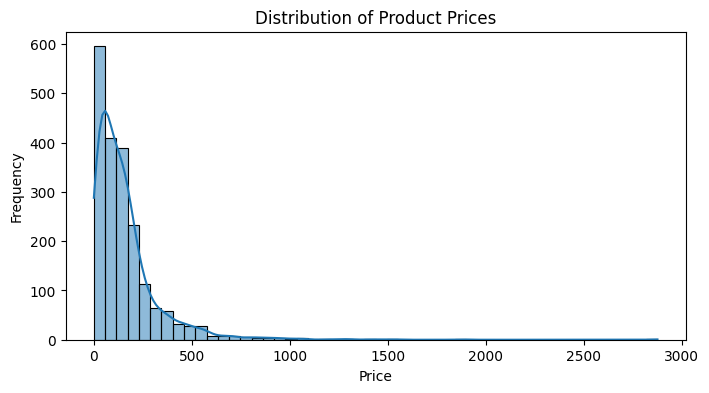

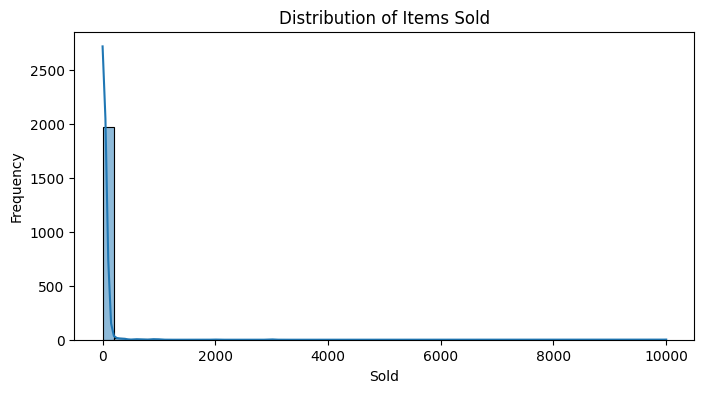

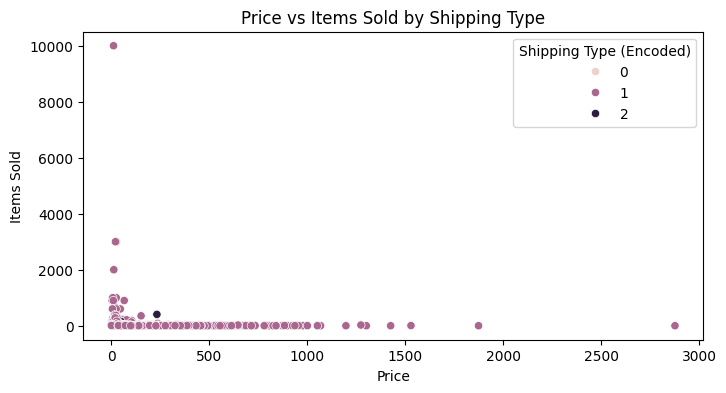

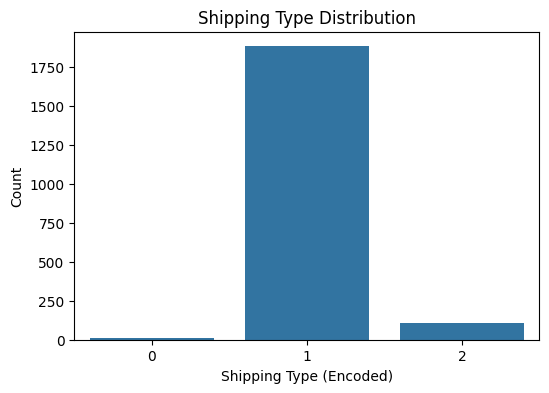

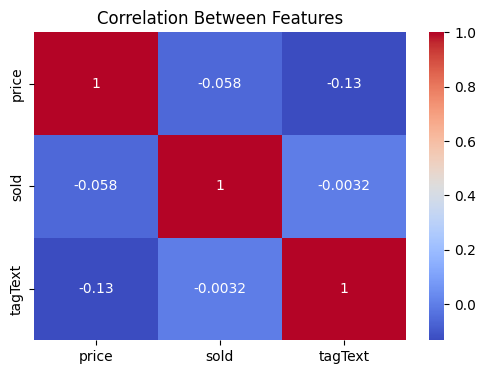

In [8]:


import seaborn as sns
import matplotlib.pyplot as plt

# 1. Distribution of Price
plt.figure(figsize=(8,4))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Distribution of Product Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# 2. Distribution of Items Sold
plt.figure(figsize=(8,4))
sns.histplot(df['sold'], bins=50, kde=True)
plt.title('Distribution of Items Sold')
plt.xlabel('Sold')
plt.ylabel('Frequency')
plt.show()

# 3. Price vs Sold Scatter Plot
plt.figure(figsize=(8,4))
sns.scatterplot(x='price', y='sold', hue='tagText', data=df)
plt.title('Price vs Items Sold by Shipping Type')
plt.xlabel('Price')
plt.ylabel('Items Sold')
plt.legend(title='Shipping Type (Encoded)')
plt.show()

# 4. Count of Shipping Tags
plt.figure(figsize=(6,4))
sns.countplot(x='tagText', data=df)
plt.title('Shipping Type Distribution')
plt.xlabel('Shipping Type (Encoded)')
plt.ylabel('Count')
plt.show()

# 5. Correlation Heatmap
plt.figure(figsize=(6,4))
sns.heatmap(df[['price', 'sold', 'tagText']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Features')
plt.show()


In [12]:
# --------------------------------------
# STEP 4: Feature Engineering (fixed)
# --------------------------------------

from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Check if productTitle is present
if 'productTitle' in df.columns:

    # 2. Apply TF-IDF to productTitle
    tfidf = TfidfVectorizer(max_features=50, stop_words='english')  # max 50 words
    productTitle_tfidf = tfidf.fit_transform(df['productTitle'])

    # 3. Convert TF-IDF matrix to DataFrame
    productTitle_tfidf_df = pd.DataFrame(productTitle_tfidf.toarray(), columns=tfidf.get_feature_names_out())

    # 4. Concatenate TF-IDF features with the original df
    df = pd.concat([df.reset_index(drop=True), productTitle_tfidf_df.reset_index(drop=True)], axis=1)

    # 5. Drop productTitle column now
    df.drop(['productTitle'], axis=1, inplace=True)

else:
    print("⚠️ 'productTitle' column already removed. You can skip this step.")


⚠️ 'productTitle' column already removed. You can skip this step.


In [13]:
# --------------------------------------
# STEP 5: Model Building
# --------------------------------------

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# 1. Split features and target
X = df.drop('sold', axis=1)
y = df['sold']

# 2. Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Initialize models
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# 4. Train models
lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

print("✅ Model training complete.")


✅ Model training complete.


In [14]:
# --------------------------------------
# STEP 6: Model Evaluation
# --------------------------------------

from sklearn.metrics import mean_squared_error, r2_score

# 1. Predict using Linear Regression
y_pred_lr = lr_model.predict(X_test)

# 2. Predict using Random Forest
y_pred_rf = rf_model.predict(X_test)

# 3. Evaluate Linear Regression
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# 4. Evaluate Random Forest
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# 5. Print evaluation results
print("🔷 Linear Regression:")
print(f"   🔹 MSE: {mse_lr:.2f}")
print(f"   🔹 R² Score: {r2_lr:.2f}")

print("\n🔶 Random Forest Regressor:")
print(f"   🔸 MSE: {mse_rf:.2f}")
print(f"   🔸 R² Score: {r2_rf:.2f}")


🔷 Linear Regression:
   🔹 MSE: 23560.88
   🔹 R² Score: 0.11

🔶 Random Forest Regressor:
   🔸 MSE: 8702.87
   🔸 R² Score: 0.67
